<a href="https://colab.research.google.com/github/Kseniia-Kuzina/BDT-DZ/blob/main/base_line_3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Решение задачи регрессии с помощью нейронных сетей

Определение стоимости недвижимости из набора данных [California Housing Data Set](https://developers.google.com/machine-learning/crash-course/california-housing-data-description).

Учебный курс "[Программирование глубоких нейронных сетей на Python](https://openedu.ru/course/urfu/PYDNN/)".

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
""" посмотрим, какие файлы храняться в директории """
import os
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dl-urfu-regression/sample_submission.csv
/kaggle/input/dl-urfu-regression/train.csv
/kaggle/input/dl-urfu-regression/test.csv


## Загружаем данные

In [ ]:
train_df = pd.read_csv('/kaggle/input/dl-urfu-regression/train.csv')
test_df = pd.read_csv('/kaggle/input/dl-urfu-regression/test.csv')
sample_submission = pd.read_csv('/kaggle/input/dl-urfu-regression/sample_submission.csv', index_col='id')

**Описание данных**

California Housing содержит данные о средней стоимость домов в Калифорнии для квартала. Файл с данными содержит следующие столбцы:

*   **longitude** - долгота квартала с недвижимостью.
*   **latitude** - широта квартала с недвижимостью.
*   **housing_median_age** - медиана возраста домов в квартале.
*   **total_rooms** - общее колиичество комнат в квартале.
*   **total_bedrooms** - общее количество спален в квартале.
*   **population** - население квартала.
*   **households** - количество "домохозяйств" в квартале (групп людей живущих вместе в одном доме. Как правило это семьи).
*   **median_income** - медианный доход в квартале.
*   **median_house_value** - медианная стоимость дома в квартале.



In [ ]:
"""Смотрим на случайные 3 записи в нашем тренировочном наборе"""
train_df.sample(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
8179,-118.07,33.79,26.0,4422.0,624.0,1936.0,625.0,6.4288,320700.0
454,-118.03,33.97,39.0,2126.0,434.0,1103.0,433.0,3.2852,196200.0
3680,-118.33,33.99,43.0,2224.0,550.0,1598.0,545.0,2.8274,122500.0


In [ ]:
"""Смотрим на случайные 3 записи в нашем тестовом наборе"""
test_df.sample(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
633,-118.02,34.13,32.0,3308.0,718.0,1803.0,667.0,3.9464
390,-117.65,33.45,15.0,7468.0,1275.0,3033.0,1217.0,5.4900
1456,-119.70,34.36,35.0,1604.0,334.0,904.0,337.0,4.7411


In [ ]:
"""Смотрим на случайные 3 записи в шаблоне для ответов"""
sample_submission.sample(3)

,median_house_value
id,
1258,0.1258
1409,0.1409
311,0.3110


## Постановка задачи регрессии

Необходимо определить медианную стоимость дома в квартале, зная все остальные признаки.

**Целевая переменная**: `median_house_value`

**Признаки**: `longitude, latitude, housing_median_age, total_rooms, total_bedrooms, population, households,	median_income`

Признаки подаются на вход нейронной сети, на выходе сеть должна выдать значение целевой переменной - `median_house_value`

In [ ]:
"""Выделяем данные для обучения и преобразуем их в массивы numpy.
Функция pop() возвращает нам указанный столбец и одновременно удаляет его из таблицы.
Таким образом, когда мы присваиваем df_train в переменную x_train,
там уже нет столбца с метками правильных ответов median_house_value """
y_train = train_df.pop('median_house_value').values
x_train = train_df.values
x_test = test_df.values

In [ ]:
"""Убедимся, что количество столбцов в данных совпадает"""
x_train.shape, x_test.shape

((17000, 8), (3000, 8))

**Стандартизация данных**

Вычитаем среднее значение и делим на стандартное отклонение

In [ ]:
# Среднее значение
mean = x_train.mean(axis=0)
# Стандартное отклонение
std = x_train.std(axis=0)
x_train -= mean
x_train /= std
x_test -= mean
x_test /= std

## Создаем нейронную сеть

Выходной слой с одним линейным нейроном - для задачи регрессии функция активации - RELU.

In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='relu'))

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1152      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 11,521
Trainable params: 11,521
Non-trainable params: 0
_________________________________________________________________
None


**Компилируем сеть**

Функция ошибки - среднеквадратичное отклонение. Метрика - среднее абсолютное отклонение.

In [ ]:
model.compile(optimizer='nadam', loss='mse', metrics=['mae'])

## Обучаем нейронную сеть

In [ ]:
history = model.fit(x_train,
                    y_train,
                    batch_size=15,
                    epochs=300,
                    validation_split=0.1,
                    verbose=2)

Epoch 1/300
1020/1020 - 4s - loss: 25656600576.0000 - mae: 120006.8594 - val_loss: 8645241856.0000 - val_mae: 68213.7344
Epoch 2/300
1020/1020 - 2s - loss: 6842768384.0000 - mae: 59558.3359 - val_loss: 5533712896.0000 - val_mae: 54794.1211
Epoch 3/300
1020/1020 - 2s - loss: 5214822400.0000 - mae: 52655.8789 - val_loss: 4715802624.0000 - val_mae: 49988.3008
Epoch 4/300
1020/1020 - 2s - loss: 4756011008.0000 - mae: 50089.3047 - val_loss: 4465401344.0000 - val_mae: 48746.8125
Epoch 5/300
1020/1020 - 2s - loss: 4584791552.0000 - mae: 48924.7773 - val_loss: 4287238400.0000 - val_mae: 47967.6836
Epoch 6/300
1020/1020 - 2s - loss: 4498027520.0000 - mae: 48290.2578 - val_loss: 4215174912.0000 - val_mae: 47758.6523
Epoch 7/300
1020/1020 - 2s - loss: 4448713216.0000 - mae: 47888.2383 - val_loss: 4209427456.0000 - val_mae: 47673.6328
Epoch 8/300
1020/1020 - 2s - loss: 4409099264.0000 - mae: 47530.1562 - val_loss: 4164114944.0000 - val_mae: 46577.9336
Epoch 9/300
1020/1020 - 2s - loss: 4379190784.

## Визуализация качества обучения

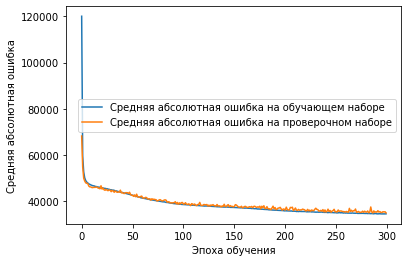

In [ ]:
plt.plot(history.history['mae'],
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'],
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

## Готовим данные для теста на liderboard

Делаем предсказания на тестовом наборе данных

In [ ]:
"""делаем предсказания по всем тестовым данным"""
predictions = model.predict(x_test)
predictions

array([[ 52586.09 ],
       [ 77758.03 ],
       [ 48188.75 ],
       ...,
       [302668.62 ],
       [ 85900.016],
       [119662.08 ]], dtype=float32)

Пишем результаты предсказаний в шаблон "sample_submission"

In [ ]:
"""используем файл с правильным шаблоном формата записи ответов и пишем в него наши предсказания"""
sample_submission['median_house_value'] = predictions

Записываем ответы для проверки на liderboard

In [ ]:
"""to_csv - пишет табличные данные в файл '.csv' """
sample_submission.to_csv('sample_submission.csv')